In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import xml.etree.ElementTree as ET

## 1 Slike za riječi i linije + HDF5 file-ovi

**Napomena**: Ovaj dio se pokreće jednom. Ukoliko već imate odgovarajuće HDF5 file-ove kao ulaz u HTR-flor model, ne treba se pokretati opet.

### 1.1 Kreiranje labela pojedinačnih riječi i linija teksta

Pomoćna funkcija za čitanje sadržaja XML file-ova koji se vežu za izvorne slike tekstova.

In [ ]:
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    filename = root.find("filename").text

    size_node = root.find("size")
    h = int(size_node.find("height").text)
    w = int(size_node.find("width").text)

    for w_idx, boxes in enumerate(root.iter("object")):
        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        name = str(boxes.find("name").text).upper()

        row = [filename, w_idx, w, h, xmin, ymin, xmax, ymax, name]
        list_with_all_boxes.append(row)

    return list_with_all_boxes

**Prva faza u kreiranju labela riječi**

Generisanje txt file-a s nazivom word_labels.txt u ovom formatu:
filename|w_idx|w|h|xmin|ymin|xmax|ymax|name

Svaka linija file-a opisuje jednu riječ na slici, zasad se za sve riječi s jedne slike navodi originalno ime slike.

In [ ]:
def generate_word_labels(path, labels):
    with open(f"{path}/word_labels.txt", "w", encoding="utf8") as file:
        for label in labels:
            xml_file = f"{path}/{label}"
            boxes = read_content(xml_file)
            label = label.removesuffix(".xml")
            for box in boxes:
                b = [str(i) for i in box]
                file.write(f'{"|".join(b)}\n')

**Prva faza u kreiranju labela linija teksta**

Generisanje txt file-a, gdje je svaki red formata:
filename|l_idx|w|h|l_xmin|l_ymin|l_xmax|l_ymax|text

Svaka linija file-a opisuje jednu liniju teksta na slici, zasad se za sve linije s jedne slike navodi originalno ime slike.

**Verzija 1**

Generiše se txt file s nazivom line_labels.txt. Pripadnost liniji se procjenjuje prema visini srednje linije bounding box-a.

In [ ]:
from sklearn.cluster import DBSCAN

def generate_line_labels(path, labels):
    with open(f"{path}/line_labels.txt", "w", encoding="utf8") as file:
        for label in labels:
            xml_file = f"{path}/{label}"
            boxes = read_content(xml_file)
            label = label.removesuffix(".xml")
            w0, h0 = boxes[0][2], boxes[0][3]
            filename0 = boxes[0][0]
            per_line = h0 // 11 + 2
            regions = [((i + 1) * per_line, []) for i in range(11)]
            regions.append((h0, []))
            middle = [(box[5] + box[7]) // 2 for box in boxes]
            distances = [[abs(i - j) for j in middle] for i in middle]
            cluster = DBSCAN(eps=25, min_samples=1, metric="precomputed").fit(distances)
            clusters = [i for i in cluster.labels_]
            regions = {}
            for clust, box in list(zip(clusters, boxes)):
                if regions.get(clust, None) is None:
                    regions[clust] = [box]
                else:
                    regions[clust].append(box)

            for l_idx, (clust, boxes) in enumerate(regions.items()):
                boxes = list(sorted(boxes, key=lambda box: box[3]))
                text = " ".join([box[-1] for box in boxes])
                text = text.strip(" ")
                if len(text) == 0:
                    continue
                l_x_min = min([box[4] for box in boxes])
                l_y_min = min([box[5] for box in boxes])
                l_x_max = max([box[6] for box in boxes])
                l_y_max = max([box[7] for box in boxes])
                line = [
                    filename0,
                    l_idx,
                    w0,
                    h0,
                    l_x_min,
                    l_y_min,
                    l_x_max,
                    l_y_max,
                    text,
                ]
                line = "|".join([str(el) for el in line])
                file.write(f"{line}\n")

**Verzija 2**

Generiše se txt file s nazivom line_labels_m.txt. Pripadnost liniji se procjenjuje prema x-koordinatama uzastopnih riječi.

In [ ]:
# Pomoćna funkcija za spajanje teksta pojedinačnih riječi u liniju, kontrolisano dodavanje razmaka u ovisnosti od interpunkcije
import re

def assemble_text_with_spaces(boxes):
    text_parts = []
    punctuation = {'.', ',', '!', '?', ':', ';', }

    for i, box in enumerate(boxes):
        curr_text = box[-1]
        text_parts.append(curr_text)

        next_text = boxes[i + 1][-1] if i + 1 < len(boxes) else None

        if curr_text in punctuation:
            text_parts.append(" ")
        else:
            if next_text and next_text not in punctuation:
                text_parts.append(" ")

    text = "".join(text_parts)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
def generate_line_labels_m(path, labels):
    with open(f"{path}/line_labels_m.txt", "w", encoding="utf8") as file:
        for label in labels:
            xml_file = f"{path}/{label}"
            boxes = read_content(xml_file)

            if not boxes:
                continue

            label = label.removesuffix(".xml")
            w0, h0 = boxes[0][2], boxes[0][3]
            filename0 = boxes[0][0]

            lines = []
            current_line = []

            for i in range(0, len(boxes)):
                prev_x = boxes[i - 1][4] if i > 0 else None
                curr_x = boxes[i][4]

                if prev_x is not None and curr_x < prev_x:
                    lines.append(current_line)
                    current_line = [boxes[i]]
                else:
                    current_line.append(boxes[i])

            if current_line:
                lines.append(current_line)

            for l_idx, line_boxes in enumerate(lines):
                line_boxes = sorted(line_boxes, key=lambda box: box[4])

                text = assemble_text_with_spaces(line_boxes)

                if not text:
                    continue

                l_x_min = min(box[4] for box in line_boxes)
                l_y_min = min(box[5] for box in line_boxes)
                l_x_max = max(box[6] for box in line_boxes)
                l_y_max = max(box[7] for box in line_boxes)

                line = [
                    filename0,
                    l_idx,
                    w0,
                    h0,
                    l_x_min,
                    l_y_min,
                    l_x_max,
                    l_y_max,
                    text,
                ]
                line_str = "|".join(str(el) for el in line)
                file.write(f"{line_str}\n")

**Poziv funkcija za generisanje labela**

File-ovi word_labels.txt, line_labels.txt i line_labels_m.txt će se kreirati u folder-u ground_truth.

In [ ]:
path = "/content/drive/MyDrive/HTR_bos3/mix/ground_truth"
labels = os.listdir(path)
labels = [l for l in labels if l.endswith(".xml")]

generate_word_labels(path, labels)
generate_line_labels(path, labels)
generate_line_labels_m(path, labels)

### 1.2 Kreiranje slika pojedinačnih riječi / linija teksta

Pomoćna funkcija, vraća dio slike obuhvaćen pravougaonikom.

In [ ]:
def extract_rectangle(image, top_left, bottom_right, wiggle_room=None):
    if wiggle_room is not None:
        w, h, _ = image.shape
        x1p, y1p = top_left
        x2p, y2p = bottom_right

        top_left = [
            x1p - wiggle_room if 0 <= x1p - wiggle_room <= w else x1p,
            y1p - wiggle_room if 0 <= y1p - wiggle_room <= h else y1p,
        ]
        bottom_right = [
            x2p + wiggle_room if 0 <= x2p + wiggle_room <= w else x2p,
            y2p + wiggle_room if 0 <= y2p + wiggle_room <= h else y2p,
        ]
    x1, y1 = top_left
    x2, y2 = bottom_right
    extracted_region = image[y1:y2, x1:x2]
    return extracted_region

**Generisanje slika pojedinačnih riječi**

Radi se na osnovu word_labels.txt file-a. Ove slike se spašavaju u labels_w/word folder, a u labels_w se kreira i file word.txt u kojem se zapisuju labele za slike pojedinačnih riječi (naziv će sada biti [originalni naziv slike]_[index riječi]). Odnosno, svaki red u word.txt će imati strukturu: filename_w_idx|w_idx|w|h|xmin|ymin|xmax|ymax|name

In [ ]:
import cv2

word_labels = "/content/drive/MyDrive/HTR_bos3/mix/ground_truth/word_labels.txt"

path = "/content/drive/MyDrive/HTR_bos3/mix/images"

labels = os.listdir(path)
labels = [l for l in labels if l.endswith(".xml")]

def generate_word_images(word_labels, src, dest):
    with open(word_labels, "r", encoding="utf8") as read:
        with open(f"{dest}/word.txt", "w", encoding="utf8") as write:
            while line := read.readline():
                line = line.removesuffix("\n").split("|")
                filename, word_idx, w, h, xmin, ymin, xmax, ymax, word = line
                img = cv2.imread(f"{src}/{filename}")
                if img is None:
                    print(f"{src}/{filename}")
                word_img = extract_rectangle(img, [int(xmin), int(ymin)], [int(xmax), int(ymax)])
                filename = filename.removesuffix(".jpg")
                img_path = f"{dest}/word/{filename}_{word_idx}.jpg"
                try:
                    cv2.imwrite(img_path, word_img)
                    line[0] = f"{filename}_{word_idx}.jpg"
                    write.write(f"{'|'.join(line)}\n")
                except Exception as e:
                    print(e)

labels_w_path = "/content/drive/MyDrive/HTR_bos3/mix/labels_w"
if not os.path.isdir(labels_w_path):
    os.mkdir(labels_w_path)

labels_w_word_path = "/content/drive/MyDrive/HTR_bos3/mix/labels_w/word"
if not os.path.isdir(labels_w_word_path):
    os.mkdir(labels_w_word_path)

generate_word_images(word_labels, path, labels_w_path)

**Generisanje slika pojedinačnih linija teksta**

**Verzija 1**

Radi se na osnovu line_labels.txt file-a. Ove slike se spašavaju u labels_l/line folder, a u labels_l se kreira i file line.txt u kojem se zapisuju labele za slike pojedinačnih linija (naziv će sada biti [originalni naziv slike]_[index linije]). Odnosno, svaki red u word.txt će imati strukturu: filename_l_idx|l_idx|w|h|l_xmin|l_ymin|l_xmax|l_ymax|text

In [ ]:
import cv2

line_labels = "/content/drive/MyDrive/HTR_bos3/mix/ground_truth/line_labels.txt"

path = "/content/drive/MyDrive/HTR_bos3/mix/images"

labels = os.listdir(path)
labels = [l for l in labels if l.endswith(".xml")]

def generate_line_images(line_labels, src, dest):
    with open(line_labels, "r", encoding="utf8") as read:
        with open(f"{dest}/line.txt", "w", encoding="utf8") as write:
            while line := read.readline():
                line = line.removesuffix("\n").split("|")
                filename, l_idx, w, h, l_x_min, l_y_min, l_x_max, l_y_max, text = line
                img = cv2.imread(f"{src}/{filename}")
                line_img = extract_rectangle(img, [int(l_x_min), int(l_y_min)], [int(l_x_max), int(l_y_max)])
                filename = filename.removesuffix(".jpg")
                img_path = f"{dest}/line/{filename}_{l_idx}.jpg"
                try:
                    cv2.imwrite(img_path, line_img)
                    line[0] = f"{filename}_{l_idx}.jpg"
                    write.write(f"{'|'.join(line)}\n")
                except Exception as e:
                    print(e)

labels_l_path = "/content/drive/MyDrive/HTR_bos3/mix/labels_l"
if not os.path.isdir(labels_l_path):
    os.mkdir(labels_l_path)

labels_l_line_path = "/content/drive/MyDrive/HTR_bos3/mix/labels_l/line"
if not os.path.isdir(labels_l_line_path):
    os.mkdir(labels_l_line_path)

generate_line_images(line_labels, path, labels_l_path)

**Verzija 2**

Radi se na osnovu line_labels_m.txt file-a. Ove slike se spašavaju u labels_l_m/line folder, a u labels_l_m se kreira i file line.txt u kojem se zapisuju labele za slike pojedinačnih linija (naziv će sada biti [originalni naziv slike]_[index linije]). File line.txt će imati istu strukturu kao u Verziji 1.

In [ ]:
line_labels_m = "/content/drive/MyDrive/HTR_bos3/mix/ground_truth/line_labels_m.txt"

path = "/content/drive/MyDrive/HTR_bos3/mix/images"

labels = os.listdir(path)
labels = [l for l in labels if l.endswith(".xml")]

labels_l_path_m = "/content/drive/MyDrive/HTR_bos3/mix/labels_l_m"
if not os.path.isdir(labels_l_path_m):
    os.mkdir(labels_l_path_m)

labels_l_line_path_m = "/content/drive/MyDrive/HTR_bos3/mix/labels_l_m/line"
if not os.path.isdir(labels_l_line_path_m):
    os.mkdir(labels_l_line_path_m)

generate_line_images(line_labels_m, path, labels_l_path_m)

### 1.3 Podjela dataset-a na trening, validacijski i testni set

Kreiraju se file-ovi trainset.txt, testset.txt i validset.txt u koje se zapisuju labele pojedinačnih slika (riječi ili linija) na osnovu labels_w/word.txt, labels_l/line.txt ili labels_l_m/line.txt. Ovi file-ovi se dodaju u labels_w, odnosno labels_l ili labels_l_m folder.

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_set(src_txt: str, out: str, train_size=0.7, val_size=0.2, test_size=0.1, random_state=None):
    assert abs(train_size+val_size+test_size-1.0) < 1e-5, "Train, validation, and test sizes must sum to 1.0"
    elements = []
    with open(src_txt, "r", encoding="utf8") as read:
        while line := read.readline():
            elements.append(line)

    if not elements:
        return 0,0,0

    train_val_data, test_data = train_test_split(elements, test_size=test_size, random_state=random_state)
    val_relative_size = val_size / (train_size + val_size)
    train_data, val_data = train_test_split(train_val_data, test_size=val_relative_size, random_state=random_state)
    with open(f"{out}/trainset.txt", "w", encoding="utf8") as train:
        for el in train_data:
            train.write(el)

    with open(f"{out}/testset.txt", "w", encoding="utf8") as test:
        for el in test_data:
            test.write(el)

    with open(f"{out}/validset.txt", "w", encoding="utf8") as val:
        for el in val_data:
            val.write(el)

    return len(train_data), len(val_data), len(test_data)

_out_w = "/content/drive/MyDrive/HTR_bos3/mix/labels_w"
_in_w = "/content/drive/MyDrive/HTR_bos3/mix/labels_w/word.txt"

_out_l = "/content/drive/MyDrive/HTR_bos3/mix/labels_l"
_in_l = "/content/drive/MyDrive/HTR_bos3/mix/labels_l/line.txt"

_out_l_m = "/content/drive/MyDrive/HTR_bos3/mix/labels_l_m"
_in_l_m = "/content/drive/MyDrive/HTR_bos3/mix/labels_l_m/line.txt"

if not os.path.isdir(_out_w):
    os.mkdir(_out_w)

if not os.path.isdir(_out_l):
    os.mkdir(_out_l)

if not os.path.isdir(_out_l_m):
    os.mkdir(_out_l_m)

split_train_set(_in_w, _out_w)
split_train_set(_in_l, _out_l)
split_train_set(_in_l_m, _out_l_m)

(1118, 320, 160)

### 1.4 Kreiranje HDF5 formata dataset-a

Ovaj korak se radi lokalno, za šta je potrebno preuzeti projekat s pratećeg Google Drive foldera ili klonirati repozitorij (detaljnije navedeno u dokumentaciji).

**Napomena**: vjerovatno će biti potrebna starija verzija Python-a, 3.11.9 je u redu.

**Uputstva za kreiranje HDF5 file-a nakon preuzimanja projekta**

1) U root-u projekta kreirati **raw** folder i u njega dodati dataset (čitav labels_w, odnosno labels_l ili labels_l_m folder s Google Drive-a, kreiran na osnovu koraka 1.1, 1.2 i 1.3).

2) U terminalu: *python -m venv .venv*

3) U terminalu:
- *source .venv/Scripts/activate* (za Windows)
- *source .venv/bin/activate* (za Linux)

4) U terminalu: *pip install -r requirements.txt*

5) U terminalu: *cd src*

6) U terminalu: *python main.py --source=*\<DATASET_NAME\> *--transform*
   - umjesto \<DATASET_NAME\> će biti labels_w, labels_l ili labels_l_m

7) Nakon ovoga bi se u root-u projekta trebao kreirati **data** folder, u kojem se nalazi odgovarajući HDF5 file.

8) Nakon toga je potrebno upload-ati čitave foldere **data** i **src** u Google Drive folder za projekat. Struktura će sada biti:

mix/

├── data/

├── ground_truth/

├── images/

├── labels_l/

├── labels_l_m/

├── labels_w/

├── src/

9) Ukoliko je potrebno kreirati dodatne HDF5 file-ove, dovoljno je pratiti uputstvo od koraka 6, pri čemu se isti samo trebaju dodati u već dodani **data** folder na Google Drive-u. Pritom je potrebno da je aktivan *virtual environment* (aktivira se u koraku 3).


## 2 Google Drive Environment

### 2.1 TensorFlow i GPU

Ovaj notebook treba pokretati korištenjem GPU, što se ovdje i provjerava.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


### 2.2 Google Drive

In [ ]:
%cd "/content/drive/MyDrive/HTR_bos3/mix/src/"

/content/drive/MyDrive/VI HTR datasets spojeno/mix/src


## 3 Treniranje HTR-flor modela

### 3.1 HTR-flor treniran na labels_w skupu podataka

#### 3.1.1 Definicija osnovnih parametara

In [ ]:
import datetime
import string

# Definicija parametara
source = "labels_w"
arch = "flor"
epochs = 300
batch_size = 64

# Definicija putanja
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.weights.h5")
os.makedirs(output_path, exist_ok=True)

# Definicija dimenzija ulaznih podataka, maksimalne dužine karaktera po ulazu i lista validnih karaktera
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]
charset_base = charset_base + "ČčĆćĐđŠšŽž"

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/labels_w.hdf5
output ../output/labels_w/flor
target ../output/labels_w/flor/checkpoint_weights.weights.h5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŠšŽž


#### 3.1.2 Učitavanje *dataset*-a

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/HTR_bos3/mix/src/')

Klasa DataGenerator omogućava učitavanje slika i pripadajućih oznaka u svrhu treniranja i evaluacije modela.

In [ ]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 8123
Validation images: 2321
Test images: 1161


#### 3.1.3 Kreiranje modela

In [ ]:
from network.model import HTRModel

# Kreiranje i kompajliranje modela
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# Učitavanje postojećeg modela (ako postoji)
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 512, 64, 16)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d               │ (None, 512, 64, 16)    │         4,640 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 512, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_1             │ (None, 512, 64, 32)    │        18,496 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 16, 40)    │        10,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 256, 16, 40)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 16, 40)    │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_2             │ (None, 256, 16, 40)    │        28,880 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 16, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 16, 48)    │        17,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256, 16, 48)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 16, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_3             │ (None, 256, 16, 48)    │        41,568 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 16, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 4, 56)     │        21,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256, 4, 56)     │            5

 Total params: 825,852 (3.15 MB)

 Trainable params: 825,340 (3.15 MB)

 Non-trainable params: 512 (2.00 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 64, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 512, 64, 16)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d               │ (None, 512, 64, 16)    │         4,640 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 512, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_1             │ (None, 512, 64, 32)    │        18,496 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 16, 40)    │        10,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 256, 16, 40)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 16, 40)    │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_2             │ (None, 256, 16, 40)    │        28,880 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 16, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 16, 48)    │        17,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256, 16, 48)    │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 16, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_gated_conv2d_3             │ (None, 256, 16, 48)    │        41,568 │
│ (FullGatedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 16, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 4, 56)     │        21,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256, 4, 56)     │            5

 Total params: 825,852 (3.15 MB)

 Trainable params: 825,340 (3.15 MB)

 Non-trainable params: 512 (2.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### 3.1.4 Treniranje modela

Sljedećim kodom se pokreće treniranje modela, pri čemu se bilježi ukupno vrijeme trajanja ovog procesa. Također, prate se vrijednosti funkcije gubitka tokom epoha, a na kraju se izdvajaju najniža validacijska greška i epoha u kojoj je postignuta. Svi relevantni rezultati i metrike se zapisuju u tekstualnu datoteku train.txt.

In [ ]:
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 163.6293
Epoch 1: val_loss improved from inf to 16.86384, saving model to ../output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 120s 771ms/step - loss: 162.7855 - val_loss: 16.8638 - learning_rate: 0.0010
Epoch 2/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - loss: 14.8964
Epoch 2: val_loss improved from 16.86384 to 15.54254, saving model to ../output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - loss: 14.8942 - val_loss: 15.5425 - learning_rate: 0.0010
Epoch 3/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - loss: 12.7447
Epoch 3: val_loss improved from 15.54254 to 10.72794, saving model to ../output/labels_w/flor/checkpoint_weights.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 91s 720ms/step - loss: 12.7393 - val_loss: 10.7279 - learning_rate: 0.0010
Epoch 4/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - loss: 9.7735
Epoch 4: val_loss improved from 10.72

#### 3.1.5 Vizualiziranje funkcije gubitka

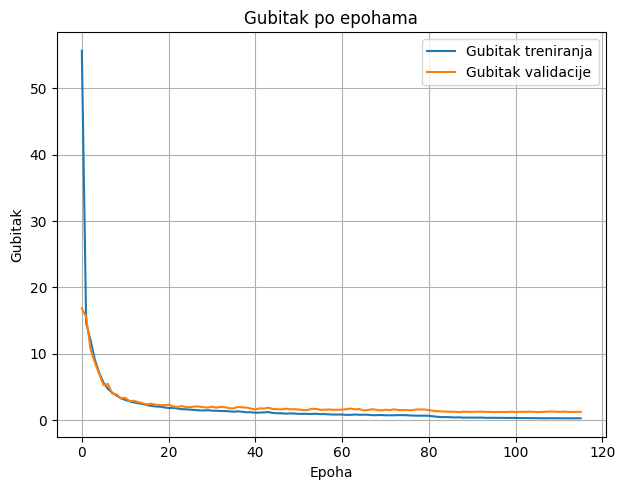

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'], label='Gubitak treniranja')
plt.plot(h.history['val_loss'], label='Gubitak validacije')
plt.title('Gubitak po epohama')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### 3.1.6 Testiranje modela

Sljedeći kod vrši predikciju nad testnim skupom koristeći trenirani model, dekodira predviđene rezultate u tekstualni oblik, učitava pripadajuće stvarne oznake i zapisuje ih zajedno u izlaznu datoteku, pri čemu se bilježi i ukupno vrijeme izvršavanja.

In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() funkcija vraća vjerovatnoće predikcije za uzorke test dataseta
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# Dekodiranje predikcija iz numeričkih vektora u stringove
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

# Učitavanje stvarnih (ground truth) stringova za test skup
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

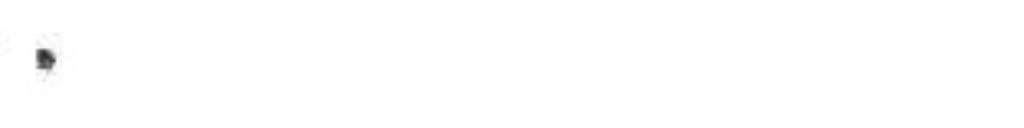

Ispravna labela:  .
Predikcija modela:  . 




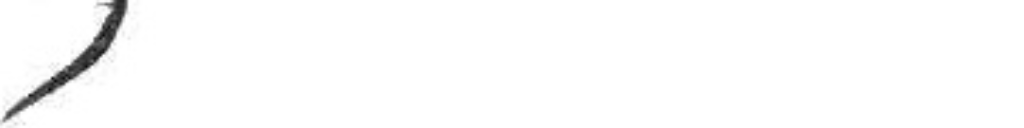

Ispravna labela:  ,
Predikcija modela:  , 




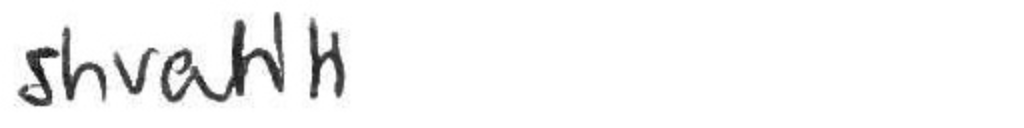

Ispravna labela:  SHVATITI
Predikcija modela:  SHVAHT 




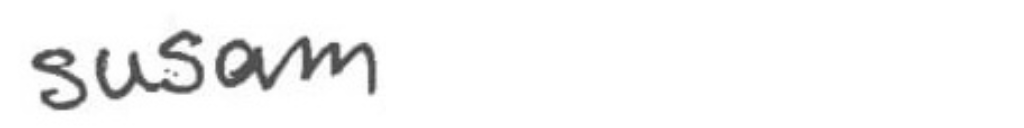

Ispravna labela:  SUSAM
Predikcija modela:  SUSAM 




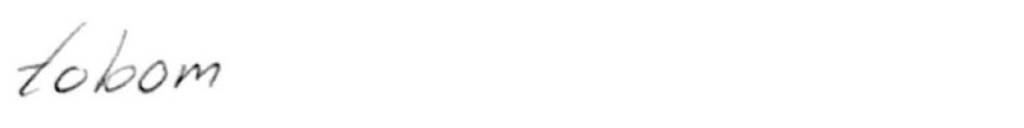

Ispravna labela:  TOBOM
Predikcija modela:  TOBOM 




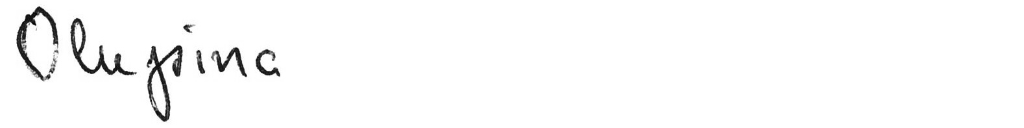

Ispravna labela:  OLUPINA
Predikcija modela:  OLUFINA 




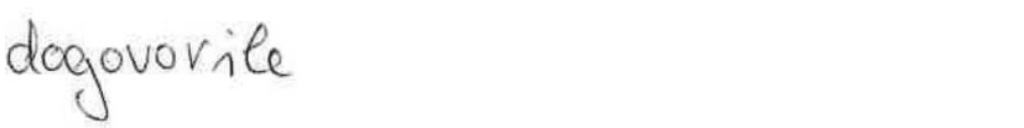

Ispravna labela:  DOGOVORILE
Predikcija modela:  DOGOVOVILE 




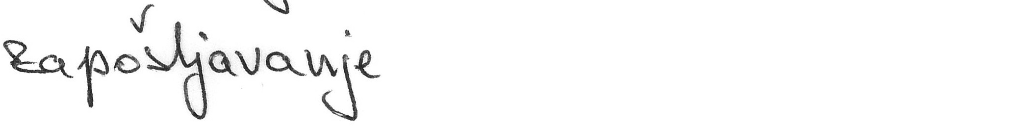

Ispravna labela:  ZAPOŠLJAVANJE
Predikcija modela:  ZAPOSLJAVANJE 




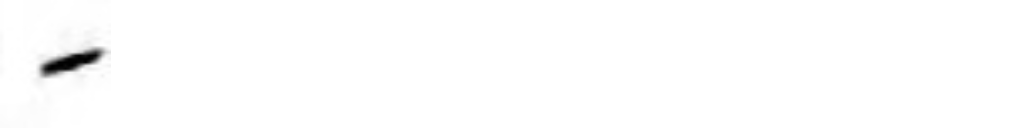

Ispravna labela:  -
Predikcija modela:  - 




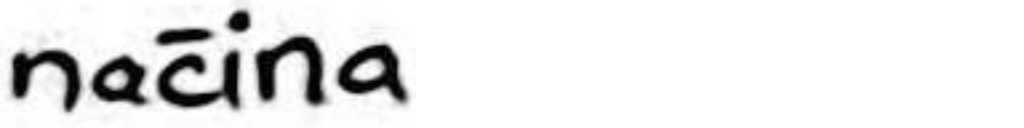

Ispravna labela:  NAČINA
Predikcija modela:  NAČINA 




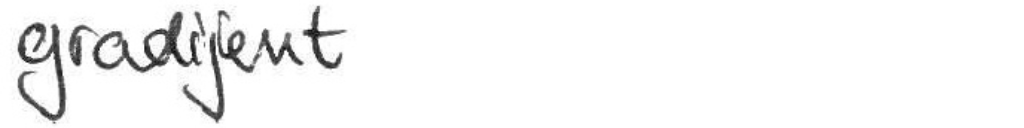

Ispravna labela:  GRADIJENT
Predikcija modela:  GRADIJENT 




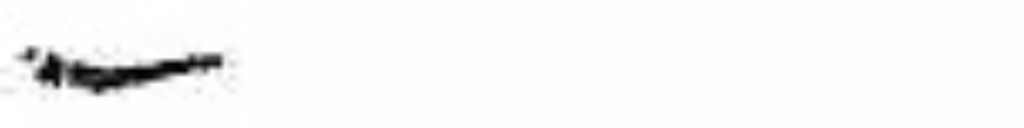

Ispravna labela:  -
Predikcija modela:  - 




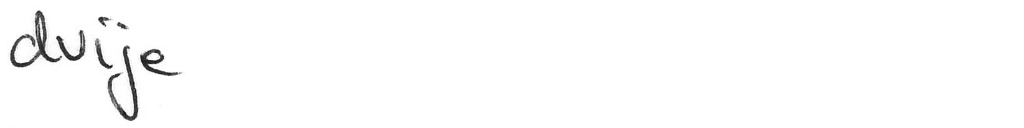

Ispravna labela:  DVIJE
Predikcija modela:  DVIJE 




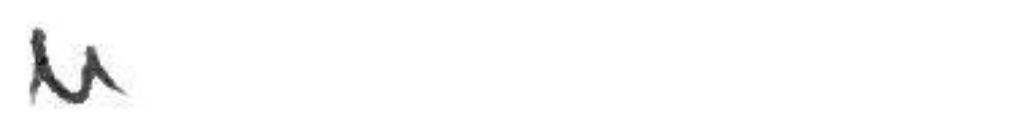

Ispravna labela:  U
Predikcija modela:  U 




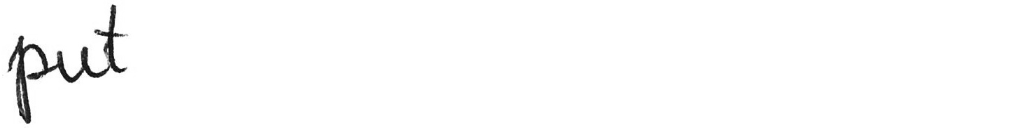

Ispravna labela:  PUT
Predikcija modela:  PUT 



In [ ]:
# Prikaz prvih 15 testnih slika zajedno s labelama i predikcijama
for i, item in enumerate(dtgen.dataset['test']['dt'][:15]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print("Ispravna labela: ", ground_truth[i])
    print("Predikcija modela: ", predicts[i], "\n")

#### 3.1.7 Metrike

In [ ]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    1161
Total time:           0:01:14.619234
Time per item:        0:00:00.064272

Metrics:
Character Error Rate: 0.06568885
Word Error Rate:      0.19638243
Sequence Error Rate:  0.19638243


------------------
### 3.2 HTR-flor treniran na labels_l skupu podataka

#### 3.2.1 Definicija osnovnih parametara

In [ ]:
import datetime
import string

source = "labels_l"
arch = "flor"
epochs = 300
batch_size = 16

source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.weights.h5")
os.makedirs(output_path, exist_ok=True)

input_size = (1024, 128, 1)
max_text_length = 256
charset_base = string.printable[:95]
charset_base = charset_base + "ČčĆćĐđŠšŽž"

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/labels_l.hdf5
output ../output/labels_l/flor
target ../output/labels_l/flor/checkpoint_weights.weights.h5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŠšŽž


#### 3.2.2 Učitavanje *dataset*-a

In [ ]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

[valid] Skipped 1 samples with labels longer than max_time_steps (256)
Train images: 1118
Validation images: 319
Test images: 160


#### 3.2.3 Kreiranje modela

In [ ]:
from network.model import HTRModel

# Kreiranje i kompajliranje modela
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)

# Učitavanje postojećeg modela (ako postoji)
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

#### 3.2.4 Treniranje modela

In [ ]:
start_time = datetime.datetime.now()

# Treniranje modela
h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 6.2033
Epoch 1: val_loss improved from inf to 16.81571, saving model to ../output/labels_l/flor/checkpoint_weights.weights.h5
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 304ms/step - loss: 6.1979 - val_loss: 16.8157 - learning_rate: 1.0000e-04
Epoch 2/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 7.1865
Epoch 2: val_loss did not improve from 16.81571
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - loss: 7.1699 - val_loss: 17.7625 - learning_rate: 1.0000e-04
Epoch 3/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 5.6214
Epoch 3: val_loss did not improve from 16.81571
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - loss: 5.6242 - val_loss: 18.3534 - learning_rate: 1.0000e-04
Epoch 4/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 5.2646
Epoch 4: val_loss did not improve from 16.81571
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - loss: 5.2692 - val_loss: 18.1484 - learning_rate: 1.0000e-04
Epoch 5/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 223

#### 3.2.5 Vizualiziranje funkcije gubitka

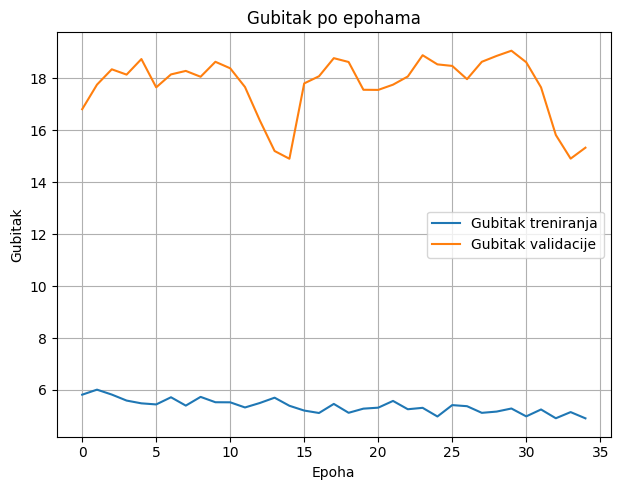

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'], label='Gubitak treniranja')
plt.plot(h.history['val_loss'], label='Gubitak validacije')
plt.title('Gubitak po epohama')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### 3.2.6 Testiranje modela

In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() funkcija vraća vjerovatnoće predikcije za uzorke test dataseta
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# Dekodiranje predikcija iz numeričkih vektora u stringove
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

# Učitavanje stvarnih (ground truth) stringova za test skup
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

Model Predict
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
CTC Decode
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 897ms/step


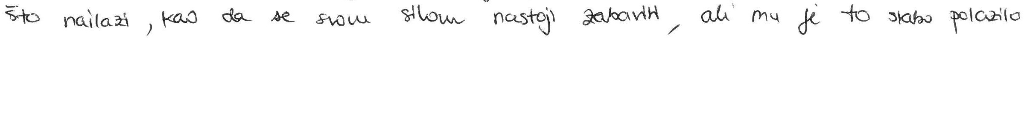

Ispravna labela:  ŠTO NAILAZI , KAO DA SE SVOM SILOM NASTOJI ZABAVITI , ALI MU JE TO SLABO POLAZILO
Predikcija modela:  ŠTO NAILAZI , KAO DA SE SVOM SILOM NASTOJI ZABAVITI , ALI NU JE TO SABO POLOSILO 




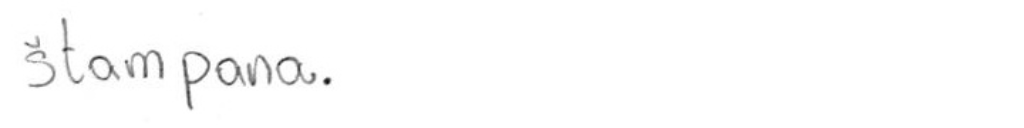

Ispravna labela:  ŠTAMPANA .
Predikcija modela:  STAM PANA. 




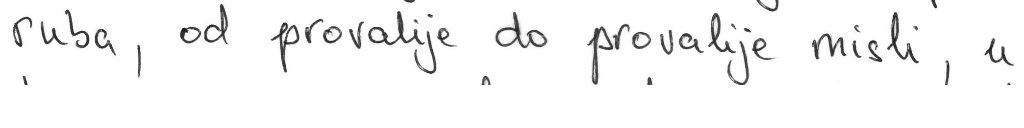

Ispravna labela:  RUBA OD PROVALIJE DO PROVALIJE MISLI U
Predikcija modela:  SUBA OD PROVALIJE DO PROVALIJE MISLI , U 




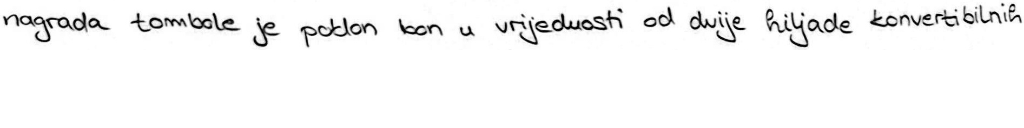

Ispravna labela:  NAGRADA TOMBOLE JE POKLON BON U VRIJEDNOSTI OD DVIJE HILJADE KONVERTIBILNIH
Predikcija modela:  NAGRADA TOMBOLE JE POKLON KON U VRIJEDNOSTI OD DVIJE HILJADE KONVERTIBILNIH 




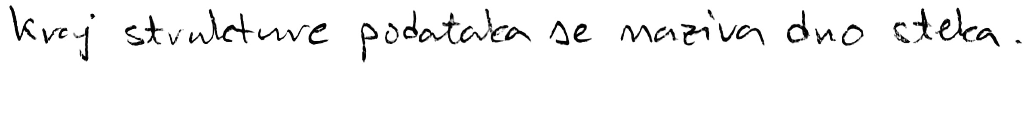

Ispravna labela:  KRAJ STRUKTURE PODATAKA SE NAZIVA DNO STEKA .
Predikcija modela:  KVEJ STRUKETUVE PODATAKA SE NAZIVA DNO STEKA . 




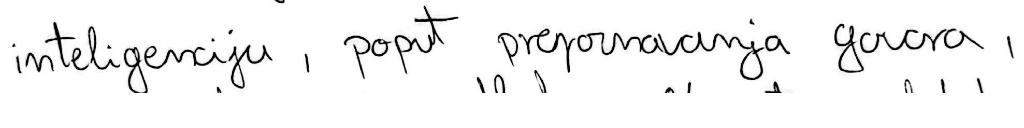

Ispravna labela:  INTELIGENCIJU , POPUT PREPOZNAVANJA GOVORA ,
Predikcija modela:  INTELIGENCIJU , POPUT PREPOZNAVANJA GAVCRA , 




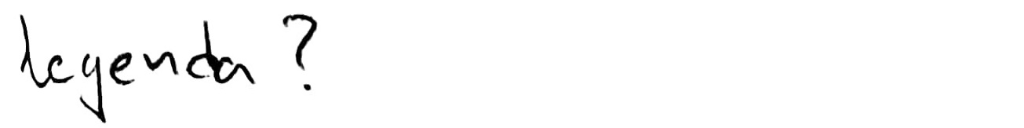

Ispravna labela:  LEGENDA ?
Predikcija modela:  KEGENDA ? 




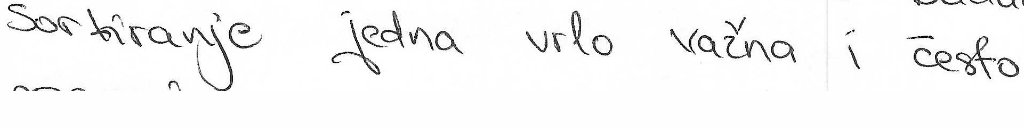

Ispravna labela:  SORTIRANJE JEDNA VRLO VAŽNA I ČESTO
Predikcija modela:  SOSBIRANJE JEDNA VRLO NAZNA I ČESTO 




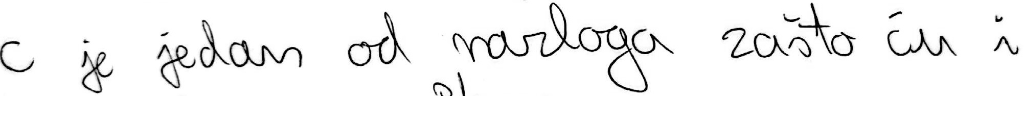

Ispravna labela:  C JE JEDAN OD RAZLOGA ZAŠTO ĆU I
Predikcija modela:  C J JEDAN OD RAZLOGA ZAŠTO ĆU I 




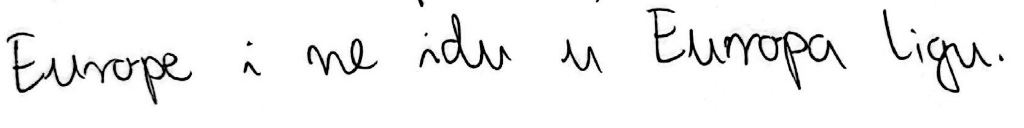

Ispravna labela:  EUROPE I NE IDU U EUROPA LIGU .
Predikcija modela:  KUROPE I NE IDU U KURPOPA LIGU . 




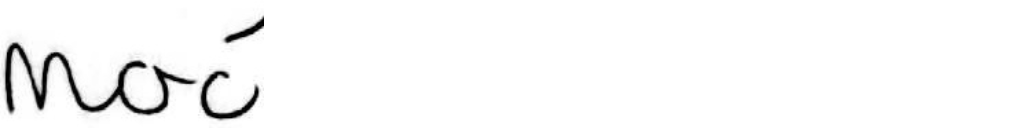

Ispravna labela:  NOĆ
Predikcija modela:  NCO 




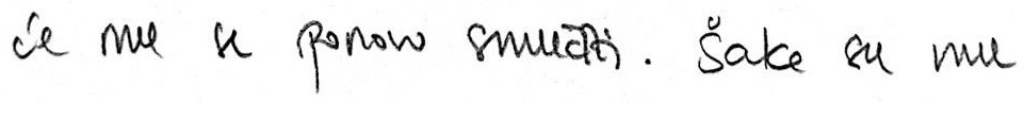

Ispravna labela:  ĆE MU SE PONOVO SMUČITI . ŠAKE SU MU
Predikcija modela:  ĆE M H PONOV SMUČTI . ŠAKE SU MU 




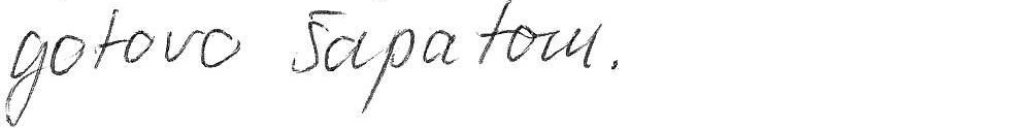

Ispravna labela:  GOTOVO ŠAPATOM .
Predikcija modela:  NOTOVO APATORU . 




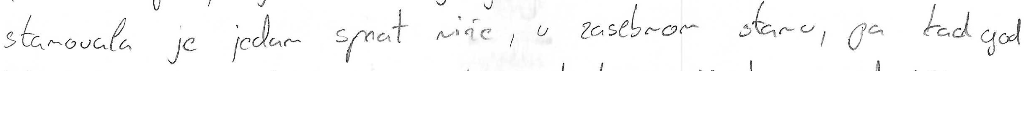

Ispravna labela:  STANOVALA JE JEDAN SPRAT NIŽE , U ZASEBNOM STANU , PA KAD GOD
Predikcija modela:  STANOVALA JE JEDAN SPRAT NIŽE , U ZASEBNOR STARU , GA BADGED 




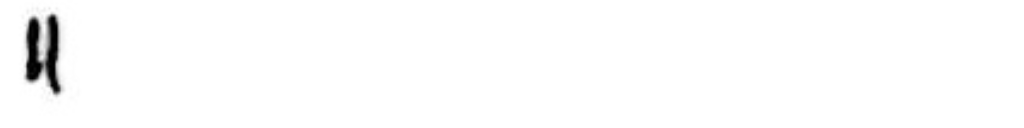

Ispravna labela:  "
Predikcija modela:  " 



In [ ]:
# Prikaz prvih 15 testnih slika zajedno s labelama i predikcijama
for i, item in enumerate(dtgen.dataset['test']['dt'][:15]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print("Ispravna labela: ", ground_truth[i])
    print("Predikcija modela: ", predicts[i], "\n")

#### 3.2.7 Metrike

In [ ]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    160
Total time:           0:00:10.958670
Time per item:        0:00:00.068492

Metrics:
Character Error Rate: 0.11644552
Word Error Rate:      0.27955509
Sequence Error Rate:  0.76875000


------------------
### 3.3 HTR-flor treniran na labels_l_m skupu podataka

#### 3.3.1 Definicija osnovnih parametara

In [ ]:
import datetime
import string

source = "labels_l_m"
arch = "flor"
epochs = 300
batch_size = 16

source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.weights.h5")
os.makedirs(output_path, exist_ok=True)

input_size = (1024, 128, 1)
max_text_length = 256
charset_base = string.printable[:95]
charset_base = charset_base + "ČčĆćĐđŠšŽž"

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/labels_l_m.hdf5
output ../output/labels_l_m/flor
target ../output/labels_l_m/flor/checkpoint_weights.weights.h5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŠšŽž


#### 3.3.2 Učitavanje *dataset*-a

In [ ]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 958
Validation images: 275
Test images: 138


#### 3.3.3 Kreiranje modela

In [ ]:
from network.model import HTRModel

# Kreiranje i kompajliranje modela
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)

# Učitavanje postojećeg modela (ako postoji)
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

#### 3.3.4 Treniranje modela

In [ ]:
start_time = datetime.datetime.now()

# Treniranje modela
h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 351.6673
Epoch 1: val_loss improved from inf to 151.87112, saving model to ../output/labels_l_m/flor/checkpoint_weights.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - loss: 349.3510 - val_loss: 151.8711 - learning_rate: 0.0010
Epoch 2/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 142.4470
Epoch 2: val_loss improved from 151.87112 to 132.07950, saving model to ../output/labels_l_m/flor/checkpoint_weights.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - loss: 142.4689 - val_loss: 132.0795 - learning_rate: 0.0010
Epoch 3/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 139.0722
Epoch 3: val_loss improved from 132.07950 to 125.17470, saving model to ../output/labels_l_m/flor/checkpoint_weights.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - loss: 139.0210 - val_loss: 125.1747 - learning_rate: 0.0010
Epoch 4/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 127.1880
Epoch 4: val_loss improved fro

#### 3.3.5 Vizualiziranje funkcije gubitka

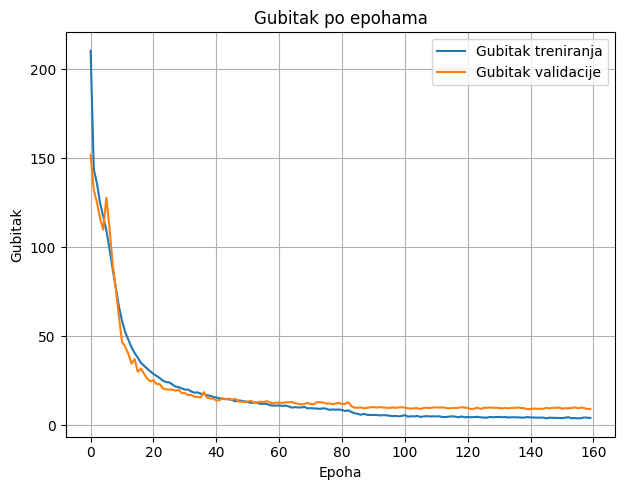

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'], label='Gubitak treniranja')
plt.plot(h.history['val_loss'], label='Gubitak validacije')
plt.title('Gubitak po epohama')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### 3.3.6 Testiranje modela

In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() funkcija vraća vjerovatnoće predikcije za uzorke test dataseta
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# Dekodiranje predikcija iz numeričkih vektora u stringove
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

# Učitavanje stvarnih (ground truth) stringova za test skup
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

Model Predict
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
CTC Decode
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


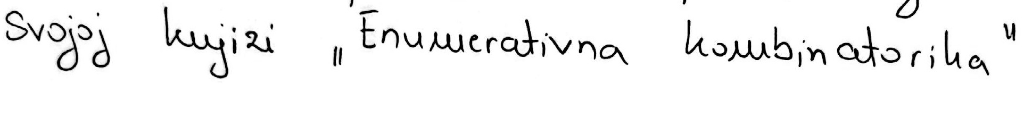

Ispravna labela:  SVOJOJ KNJIZI " ENUMERATIVNA KOMBINATORIKA "
Predikcija modela:  SVOJOJ KUJIZI " ENUMERATIVNA KOMBINATORIKA " 




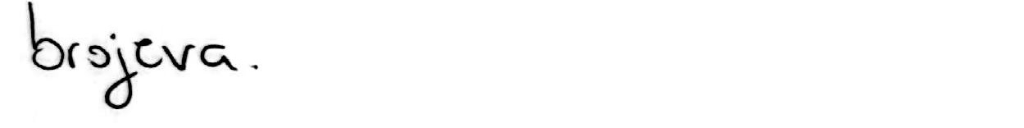

Ispravna labela:  BROJEVA.
Predikcija modela:  BROJEVA. 




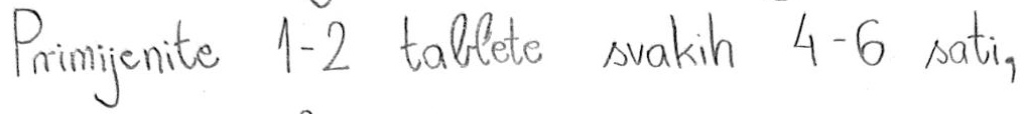

Ispravna labela:  PRIMIJENITE 1 - 2 TABLETE SVAKIH 4 - 6 SATI,
Predikcija modela:  PRIMIJENITE 1 -2 TABLETE SVAKIH 4 - 6 SATI, 




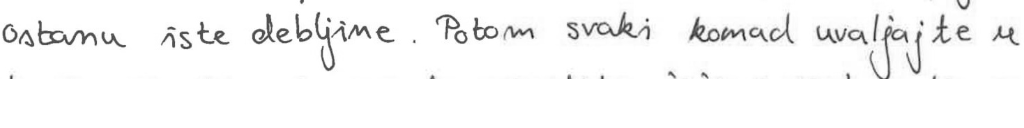

Ispravna labela:  OSTANU ISTE DEBLJINE. POTOM SVAKI KOMAD UVALJAJTE U
Predikcija modela:  OSTANU ISTE DEBLJINE. POTOM SVAKI KOMAD UVALJAJTE U 




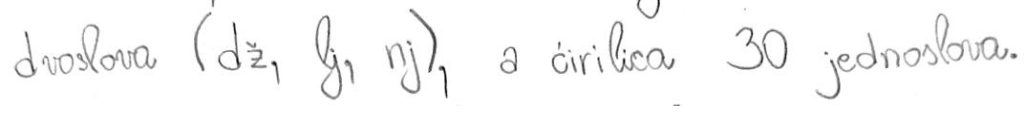

Ispravna labela:  DVOSLOVA ( DŽ, LJ, NJ ), A ĆIRILICA 30 JEDNOSLOVA.
Predikcija modela:  DVOSLOVA ( DZ, LJI NJT, A ČIRILICA S0 JEDNOSLOVA. 




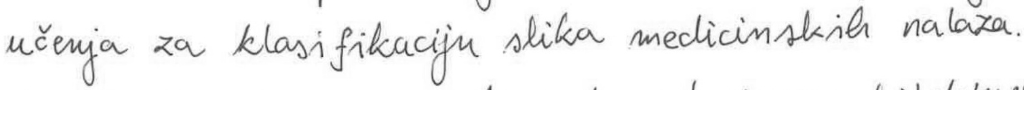

Ispravna labela:  UČENJA ZA KLASIFIKACIJU SLIKA MEDICINSKIH NALAZA.
Predikcija modela:  UČENJA ZA KLASIFIKACIJU SLIKA MEDICINSKIH NALAZA. 




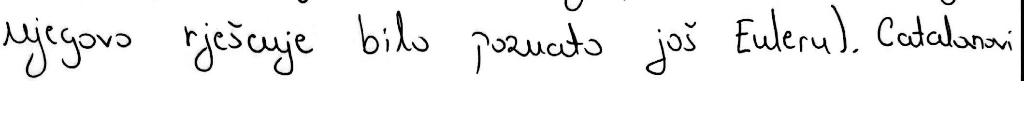

Ispravna labela:  NJEGOVO RJEŠENJE BILO POZNATO JOŠ EULERU ). CATALANOVI
Predikcija modela:  NJEGOVO RJEŠENJE BILO POZNATO JOŠ EULERU ). CATALANANI 




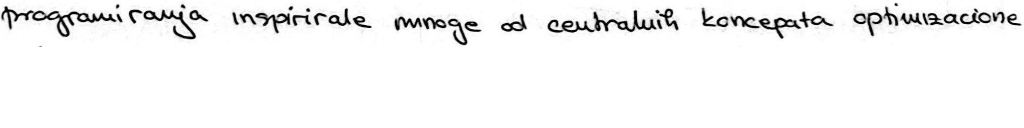

Ispravna labela:  PROGRAMIRANJA INSPIRIRALE MNOGE OD CENTRALNIH KONCEPATA OPTIMIZACIONE
Predikcija modela:  PROGRAMIRANJA INSPIRIRALE MNOGE OD CEUTNALNIH KONCEPATA OPTIMIZACIONE 




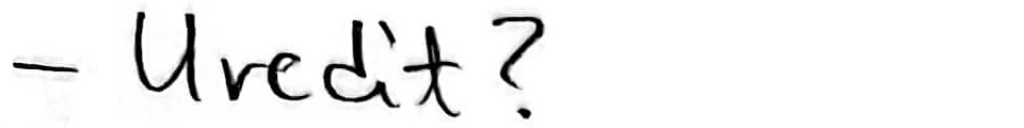

Ispravna labela:  - UREDIT?
Predikcija modela:  - U VRD+? 




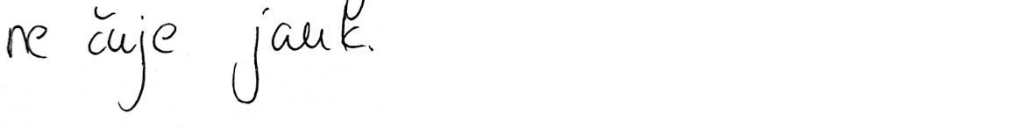

Ispravna labela:  NE ČUJE JAUK.
Predikcija modela:  NE ČUJE JALK. 




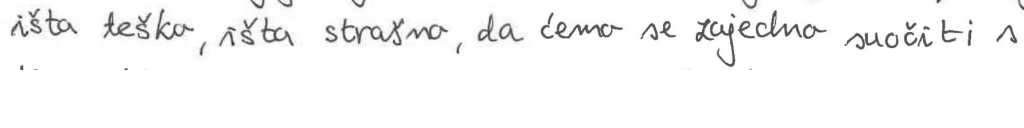

Ispravna labela:  IŠTA TEŠKO, IŠTA STRAŠNO, DA ĆEMO SE ZAJEDNO SUOČITI S
Predikcija modela:  IŠTA TEŠKO, IŠTA STRAŠNO, DA ĆEMO SE ZAJEDNO SUOČITI S 




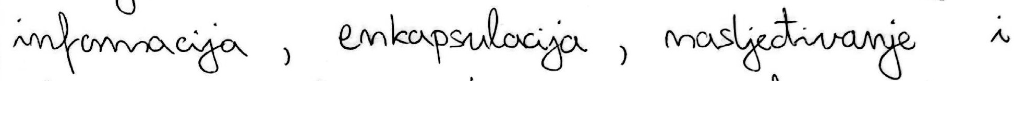

Ispravna labela:  INFORMACIJA, ENKAPSULACIJA, NASLJEĐIVANJE I
Predikcija modela:  INFORMACIJA, ENKAPSULACIJA, NASLJEĐIVANJE I 




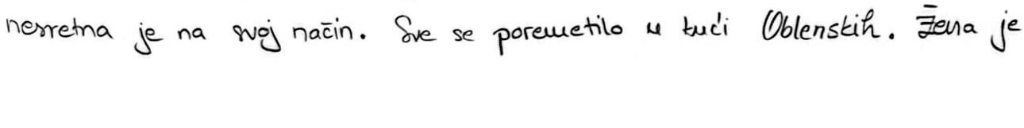

Ispravna labela:  NESRETNA JE NA SVOJ NAČIN. SVE SE POREMETILO U KUĆI OBLENSKIH. ŽENA JE
Predikcija modela:  NESRETNA JE NA SVOJ NAČIN. SVE SE POREMETILO U TUĆI OBLENSKIH. ŽENA JE 




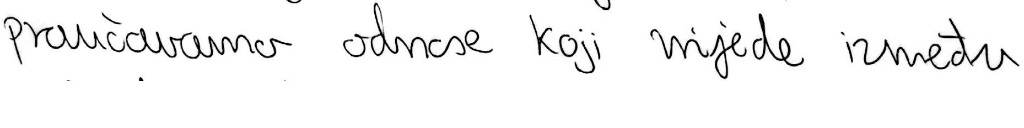

Ispravna labela:  PROUČAVAMO ODNOSE KOJI VRIJEDE IZMEĐU
Predikcija modela:  PRAUČAVAMO ODNOSE KOJI VRIJEDE IZMEDU 




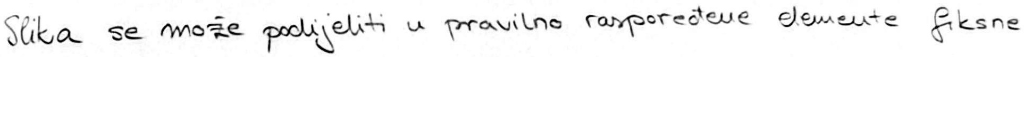

Ispravna labela:  SLIKA SE MOŽE PODIJELITI U PRAVILNO RASPOREĐENE ELEMENTE FIKSNE
Predikcija modela:  SLIKA SE MOŽE PODIJELITI U PRAVILNO RASPOREĐENE ELEMENTE FIKSNE 



In [ ]:
# Prikaz prvih 15 testnih slika zajedno s labelama i predikcijama
for i, item in enumerate(dtgen.dataset['test']['dt'][:15]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print("Ispravna labela: ", ground_truth[i])
    print("Predikcija modela: ", predicts[i], "\n")

#### 3.3.7 Metrike

In [ ]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    138
Total time:           0:00:11.718982
Time per item:        0:00:00.084920

Metrics:
Character Error Rate: 0.08123783
Word Error Rate:      0.26742280
Sequence Error Rate:  0.71739130
